In [42]:
%reset -f
%load_ext blackcellmagic
%load_ext line_profiler
def sprintf(fmt,*args):
	return fmt % (args)
def printf(fmt,*args):
	print(sprintf(fmt, *args), end="")

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit
import sys
import re
import os
import seaborn as sns

pd.set_option("display.max_columns", None)
plt.style.use("ggplot")

In [44]:
df = pd.read_csv("default_of_credit_card_clients.csv")

The reason I have decided to preprocess in this way is because I want to force the python garbage collector for each step of transformation

In [45]:
def rename_cols(df):
    new_cols = list(df.iloc[0])
    new_cols = list(map(lambda x: re.sub(r"\s", "_", x).lower(), new_cols))
    df = df.iloc[1:-1]
    df.columns = new_cols
    return df


def drop_id(df):
    return df.drop(columns=["id"])


def df_to_numeric(df):
    def my_numeric(x):
        try:
            result = np.int32(x)
            return result
        except:
            pass
        try:
            result = np.float32(x)
            return result
        except:
            return np.nan

    # set numberic data to be the best numeric data they can even be :')
    return df.apply(my_numeric)


def remove_edu_and_mar_errata(df):
    # filter out unreasonable variables and unknowns
    df["education"] = df["education"].apply(lambda x: x if 1 <= x and x <= 4 else 4)
    df["marriage"] = df["marriage"].apply(lambda x: x if 1 <= x and x <= 3 else 3)
    return df


def get_sex_dummies(df):
    # get dummy variables and appropriately label
    sex_dummies = pd.get_dummies(df["sex"])
    sex_dummies.columns = ["male", "female"]
#     return pd.concat([df, sex_dummies], sort=False)
    return pd.concat([df, sex_dummies], axis=1)


def get_edu_dummies(df):
    edu_dummies = pd.get_dummies(df["education"])
    edu_dummies.columns = ["graduate", "university", "high_school", "other_edu"]
#     return pd.concat([df, edu_dummies], sort=False)
    return pd.concat([df, edu_dummies], axis=1)


def get_mar_dummies(df):
    mar_dummies = pd.get_dummies(df["marriage"])
    mar_dummies.columns = ["married", "single", "other_mar"]
#     return pd.concat([df, mar_dummies], sort=False)
    return pd.concat([df, mar_dummies], axis=1)


def duly_payments_bool(df):
    # create booleans for duly payments for each month
    pay_columns = df.columns[5:11]
    duly_payments = []
    for c in pay_columns:
        temp = df[c].apply(lambda x: 0 if x > 0 else 1)
        duly_payments.append(temp)
    duly_payments_df = pd.concat(duly_payments, axis=1)
    duly_payments_df.columns = list(
        map(lambda x: x + "_duly", duly_payments_df.columns)
    )
#     return pd.concat([df, duly_payments_df], sort=False)
    return pd.concat([df, duly_payments_df], axis=1)

In [46]:
def prepocess_df(df, preprocessors):
    for pp in preprocessors:
        df = pp(df)
    return df


preprocessors = [
    rename_cols,
    drop_id,
    df_to_numeric,
    remove_edu_and_mar_errata,
    get_sex_dummies,
    get_edu_dummies,
    get_mar_dummies,
    duly_payments_bool,
]
df = prepocess_df(df, preprocessors)
X = df.drop(columns="default_payment_next_month")
y = df["default_payment_next_month"]

In [47]:
df.head()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month,male,female,graduate,university,high_school,other_edu,married,single,other_mar,pay_0_duly,pay_2_duly,pay_3_duly,pay_4_duly,pay_5_duly,pay_6_duly
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,1,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,0
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,1,0,1,0,0,0,1,0,1,1,1,1,1,1
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0,1,0,1,0,0,1,0,0,1,1,1,1,1,1
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,1,0,0,1,0,0,1,0,0,1,1,1,1,1,1


In [48]:
from imblearn.over_sampling import SMOTENC, SMOTE


categories = []
for i, c in enumerate(X.columns):
    u = pd.unique(X[c])
    if len(u) < 20:
        categories.append(i)
# smote_nc = SMOTENC(categorical_features=categories, random_state=0)
# X, y = smote_nc.fit_resample(X, y)

X, y = SMOTE().fit_resample(X, y)

In [49]:
X.shape, y.shape

((46728, 38), (46728,))

In [56]:
unique, counts = np.unique(X, return_counts=True)
for u, c in list(zip(unique, counts)):
    

In [34]:
def size_info(thing):
    printf("%f Mb\n", sys.getsizeof(thing) * 1024**-2)
    printf("%d bytes\n", sys.getsizeof(thing))
size_info(df)
df.head()

4.606350 Mb
4830108 bytes


,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month,male,female,graduate,university,high_school,other_edu,married,single,other_mar,pay_0_duly,pay_2_duly,pay_3_duly,pay_4_duly,pay_5_duly,pay_6_duly
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,1,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,0
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,1,0,1,0,0,0,1,0,1,1,1,1,1,1
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0,1,0,1,0,0,1,0,0,1,1,1,1,1,1
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,1,0,0,1,0,0,1,0,0,1,1,1,1,1,1


In [35]:
df.describe()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month,male,female,graduate,university,high_school,other_edu,married,single,other_mar,pay_0_duly,pay_2_duly,pay_3_duly,pay_4_duly,pay_5_duly,pay_6_duly
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.842267,1.557267,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200,0.396267,0.603733,0.352833,0.467667,0.163900,0.015600,0.455300,0.532133,0.012567,0.772733,0.852067,0.859567,0.883000,0.901067,0.897367
std,129747.661567,0.489129,0.744494,0.521405,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062,0.489129,0.489129,0.477859,0.498962,0.370191,0.123924,0.498006,0.498975,0.111396,0.419073,0.355040,0.347442,0.321426,0.298577,0.303484
min,10000.000000,1.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1000000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 1 to 30000
Data columns (total 39 columns):
limit_bal                     30000 non-null int32
sex                           30000 non-null int32
education                     30000 non-null int64
marriage                      30000 non-null int64
age                           30000 non-null int32
pay_0                         30000 non-null int32
pay_2                         30000 non-null int32
pay_3                         30000 non-null int32
pay_4                         30000 non-null int32
pay_5                         30000 non-null int32
pay_6                         30000 non-null int32
bill_amt1                     30000 non-null int32
bill_amt2                     30000 non-null int32
bill_amt3                     30000 non-null int32
bill_amt4                     30000 non-null int32
bill_amt5                     30000 non-null int32
bill_amt6                     30000 non-null int32
pay_amt1                

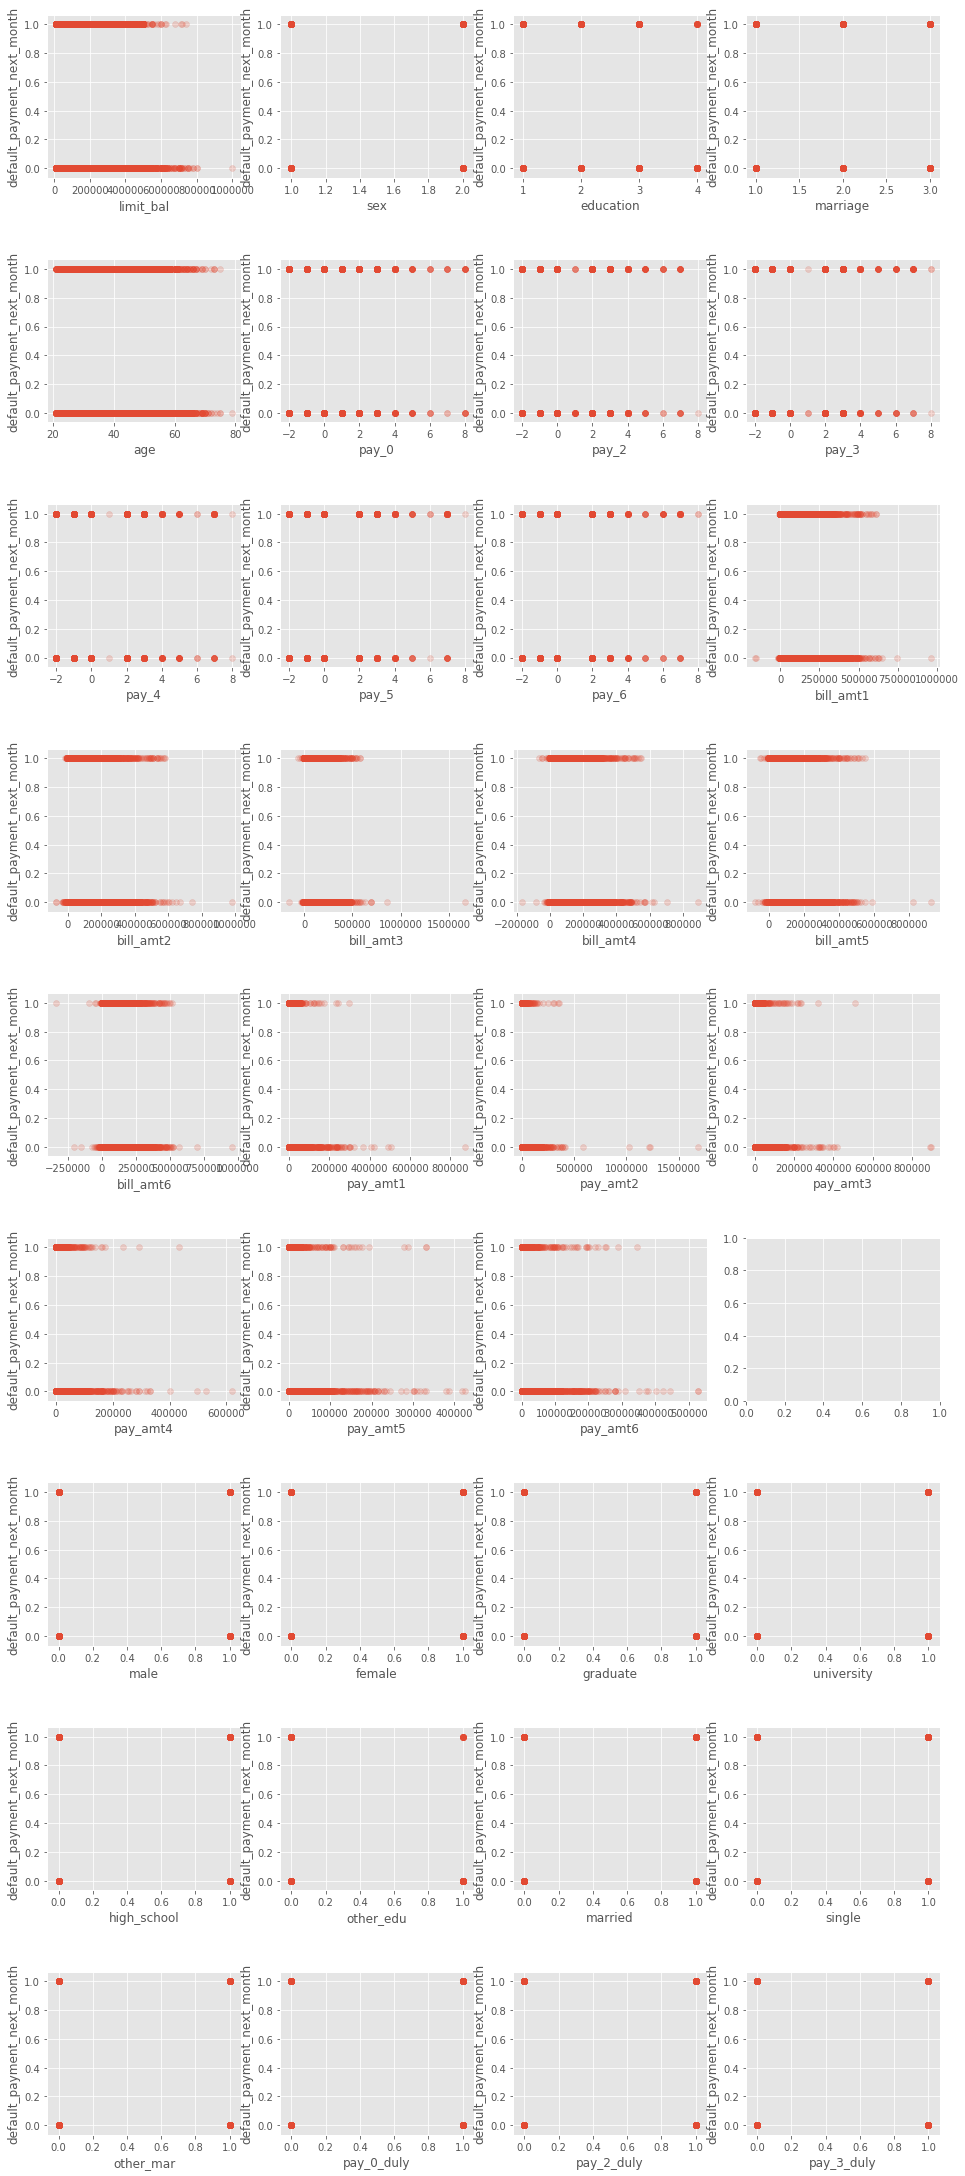

In [37]:
def plot_against_target(df, target_col="default_payment_next_month", exclude=None):
    if exclude:
        df = df.drop(columns=exclude)
    fig, ax = plt.subplots((len(df.columns) - 1) // 4, 4, figsize=(16, len(df.columns)))
    ax = ax.ravel()
    for i, a in enumerate(ax):
        if i >= len(df.columns):
            break
        if df.columns[i] == target_col:
            continue
        x = df[df.columns[i]]
        a.scatter(x, df[target_col], alpha=.2)
        a.set_xlabel(df.columns[i])
        a.set_ylabel(target_col)
    fig.subplots_adjust(hspace=.5)


plot_against_target(df)

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,male,female,graduate,university,high_school,other_edu,married,single,other_mar,pay_0_duly,pay_2_duly,pay_3_duly,pay_4_duly,pay_5_duly,pay_6_duly
limit_bal,1.000000,0.035527,-0.258037,-0.106016,0.152329,-0.308160,-0.339670,-0.326218,-0.307830,-0.289696,-0.275209,0.308929,0.300687,0.302975,0.308076,0.309613,0.302471,0.198962,0.180858,0.209116,0.206400,0.216872,0.219452,-0.035527,0.035527,0.272414,-0.157829,-0.155540,0.022236,0.102280,-0.093826,-0.041388,0.195446,0.242693,0.229582,0.217427,0.198922,0.196512
sex,0.035527,1.000000,0.014453,-0.027889,-0.093274,-0.058134,-0.071554,-0.075248,-0.065252,-0.063532,-0.054793,-0.027746,-0.025638,-0.020386,-0.017851,-0.013338,-0.013433,0.003216,0.000561,-0.004320,0.002325,-0.000231,-0.001865,-1.000000,1.000000,-0.020580,0.025753,-0.005917,0.009012,0.029320,-0.029923,0.003355,0.026634,0.041686,0.049366,0.038479,0.041935,0.038804
education,-0.258037,0.014453,1.000000,-0.142140,0.180353,0.119799,0.140233,0.130816,0.129000,0.116273,0.103667,-0.006467,-0.009585,-0.014032,-0.023911,-0.032121,-0.031910,-0.038981,-0.035036,-0.046988,-0.046822,-0.047035,-0.048734,-0.014453,0.014453,-0.826879,0.213017,0.707202,0.301723,0.156495,-0.167296,0.055469,-0.047618,-0.071758,-0.055272,-0.054793,-0.039571,-0.028480
marriage,-0.106016,-0.027889,-0.142140,1.000000,-0.437673,0.003351,0.015154,0.024715,0.020348,0.023183,0.021917,-0.035933,-0.033644,-0.035003,-0.033945,-0.033883,-0.030598,-0.003751,-0.007365,-0.001264,-0.006802,-0.004645,-0.008147,0.027889,-0.027889,0.142498,-0.055220,-0.097516,-0.004438,-0.982323,0.932935,0.265770,0.017933,0.014605,0.004434,0.011966,0.010844,0.002477
age,0.152329,-0.093274,0.180353,-0.437673,1.000000,-0.037842,-0.055759,-0.055244,-0.048741,-0.052618,-0.048608,0.054585,0.051650,0.051868,0.049489,0.046923,0.045005,0.023312,0.022080,0.022683,0.014067,0.018970,0.022362,0.093274,-0.093274,-0.097020,-0.078500,0.224705,0.006754,0.464333,-0.478118,0.070159,0.004527,0.014821,0.017514,0.008415,0.014350,0.017939
pay_0,-0.308160,-0.058134,0.119799,0.003351,-0.037842,1.000000,0.687289,0.604927,0.577731,0.550126,0.529877,0.170285,0.176971,0.175019,0.181629,0.187306,0.186611,-0.083095,-0.072278,-0.071170,-0.065021,-0.065581,-0.062913,0.058134,-0.058134,-0.161978,0.111171,0.054033,-0.035058,-0.004008,0.003958,-0.001568,-0.807211,-0.599336,-0.485941,-0.453454,-0.427086,-0.405550
pay_2,-0.339670,-0.071554,0.140233,0.015154,-0.055759,0.687289,1.000000,0.799817,0.696820,0.663261,0.634264,0.206970,0.211877,0.210037,0.214753,0.218395,0.220183,-0.076794,-0.057955,-0.053644,-0.043885,-0.037995,-0.039617,0.071554,-0.071554,-0.186315,0.133379,0.061022,-0.037790,-0.016789,0.016867,-0.003257,-0.508781,-0.841238,-0.620750,-0.513100,-0.477283,-0.453012
pay_3,-0.326218,-0.075248,0.130816,0.024715,-0.055244,0.604927,0.799817,1.000000,0.806691,0.728375,0.688335,0.181674,0.207123,0.206193,0.213644,0.216644,0.217165,-0.007128,-0.063412,-0.049014,-0.045090,-0.038381,-0.039556,0.075248,-0.075248,-0.171395,0.119618,0.060802,-0.037431,-0.025476,0.024747,0.002042,-0.387124,-0.621731,-0.824054,-0.617158,-0.521492,-0.488630
pay_4,-0.307830,-0.065252,0.129000,0.020348,-0.048741,0.577731,0.696820,0.806691,1.000000,0.858706,0.781037,0.171471,0.192900,0.211772,0.219335,0.222084,0.222986,-0.014872,-0.010477,-0.062005,-0.042581,-0.034576,-0.031751,0.065252,-0.065252,-0.166214,0.113589,0.061294,-0.033418,-0.020826,0.020062,0.002464,-0.347665,-0.516635,-0.606685,-0.794541,-0.630190,-0.543521
pay_5,-0.289696,-0.063532,0.116273,0.023183,-0.052618,0.550126,0.663261,0.728375,0.858706,1.000000,0.865811,0.178624,0.198204,0.215782,0.241462,0.245189,0.243941,-0.011494,-0.009130,0.000727,-0.051221,-0.032400,-0.026246,0.063532,-0.063532,-0.154916,0.111254,0.049605,-0.031157,-0.024372,0.024050,-0.000437,-0.324491,-0.487764,-0.516576,-0.619541,-0.773573,-0.

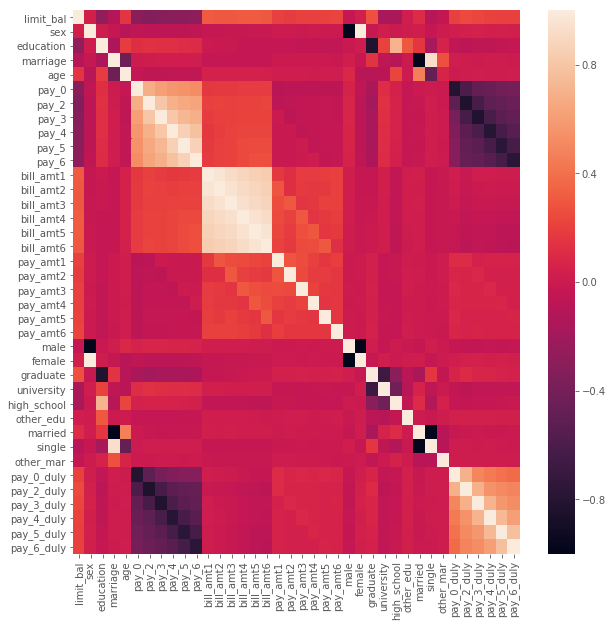

In [39]:
def do_heatmap(df):
    plt.figure(figsize=(10,10))
    init_corr = df.corr()
    display(init_corr)
    sns.heatmap(init_corr)
    plt.show()
do_heatmap(pd.DataFrame(X, columns=list(filter(lambda x: x != "default_payment_next_month", df.columns))))

In [40]:
@jit
def plot_correlations(arr, cols):
    if arr.shape[1] != cols.shape[0]:
        printf("len(arr): %d len(cols): %d\n", arr.shape[1], cols.shape[0])
        return
    for i in range(arr.shape[1]):
        for j in range(i+1, arr.shape[1]):
            plt.figure(figsize=(8,8))
            printf("%s vs %s\n", cols[i], cols[j])
            plt.xlabel(cols[i])
            plt.ylabel(cols[j])
            plotx = arr[:, i]
            ploty = arr[:, j]
#             ui = np.unique(plotx)
#             if len(ui) < 5:
#                 for k, v in enumerate(ui):
#                     print(plotx[:20], v)
# #                     print(np.where(plotx == v, plotx, plotx + k * .1)[:20])
#                     plotx = np.where(plotx == v, plotx, plotx + (k + 1) * .1)
#                     print(plotx[:20], v)
#             uj = np.unique(ploty)
#             if len(uj) < 5:
#                 for k, v in enumerate(uj):
#                     print(arr[:10, j], v)
#                     print(np.where(ploty == v, ploty, ploty + k * .1)[:20])
# #                     ploty = np.where(ploty == v, ploty, ploty + k * .1)
# #                     print(arr[:10, j], v)
            plt.scatter(plotx, ploty, alpha=.2)
            plt.show()
            plt.close()
                
# plot_correlations(np.array(X)[:, :4], np.array(X.columns)[:4])

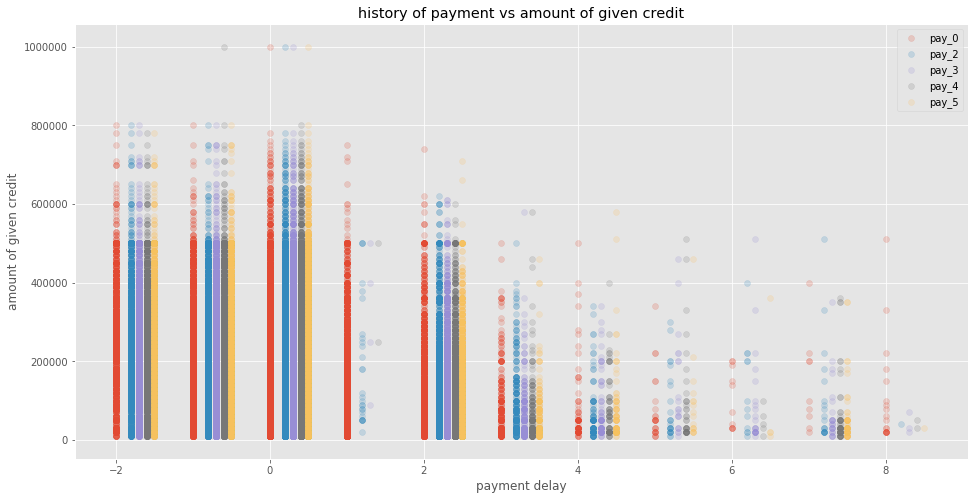

In [41]:
plt.figure(figsize=(16, 8))
for i in range(0,6):
    if i == 1:
        continue
    field = sprintf("pay_%d", i)
    plt.scatter(df[field]+.1*i,df["limit_bal"], label=field, alpha=.2)
plt.title("history of payment vs amount of given credit")
plt.xlabel("payment delay")
plt.ylabel("amount of given credit")
plt.legend()
plt.show()

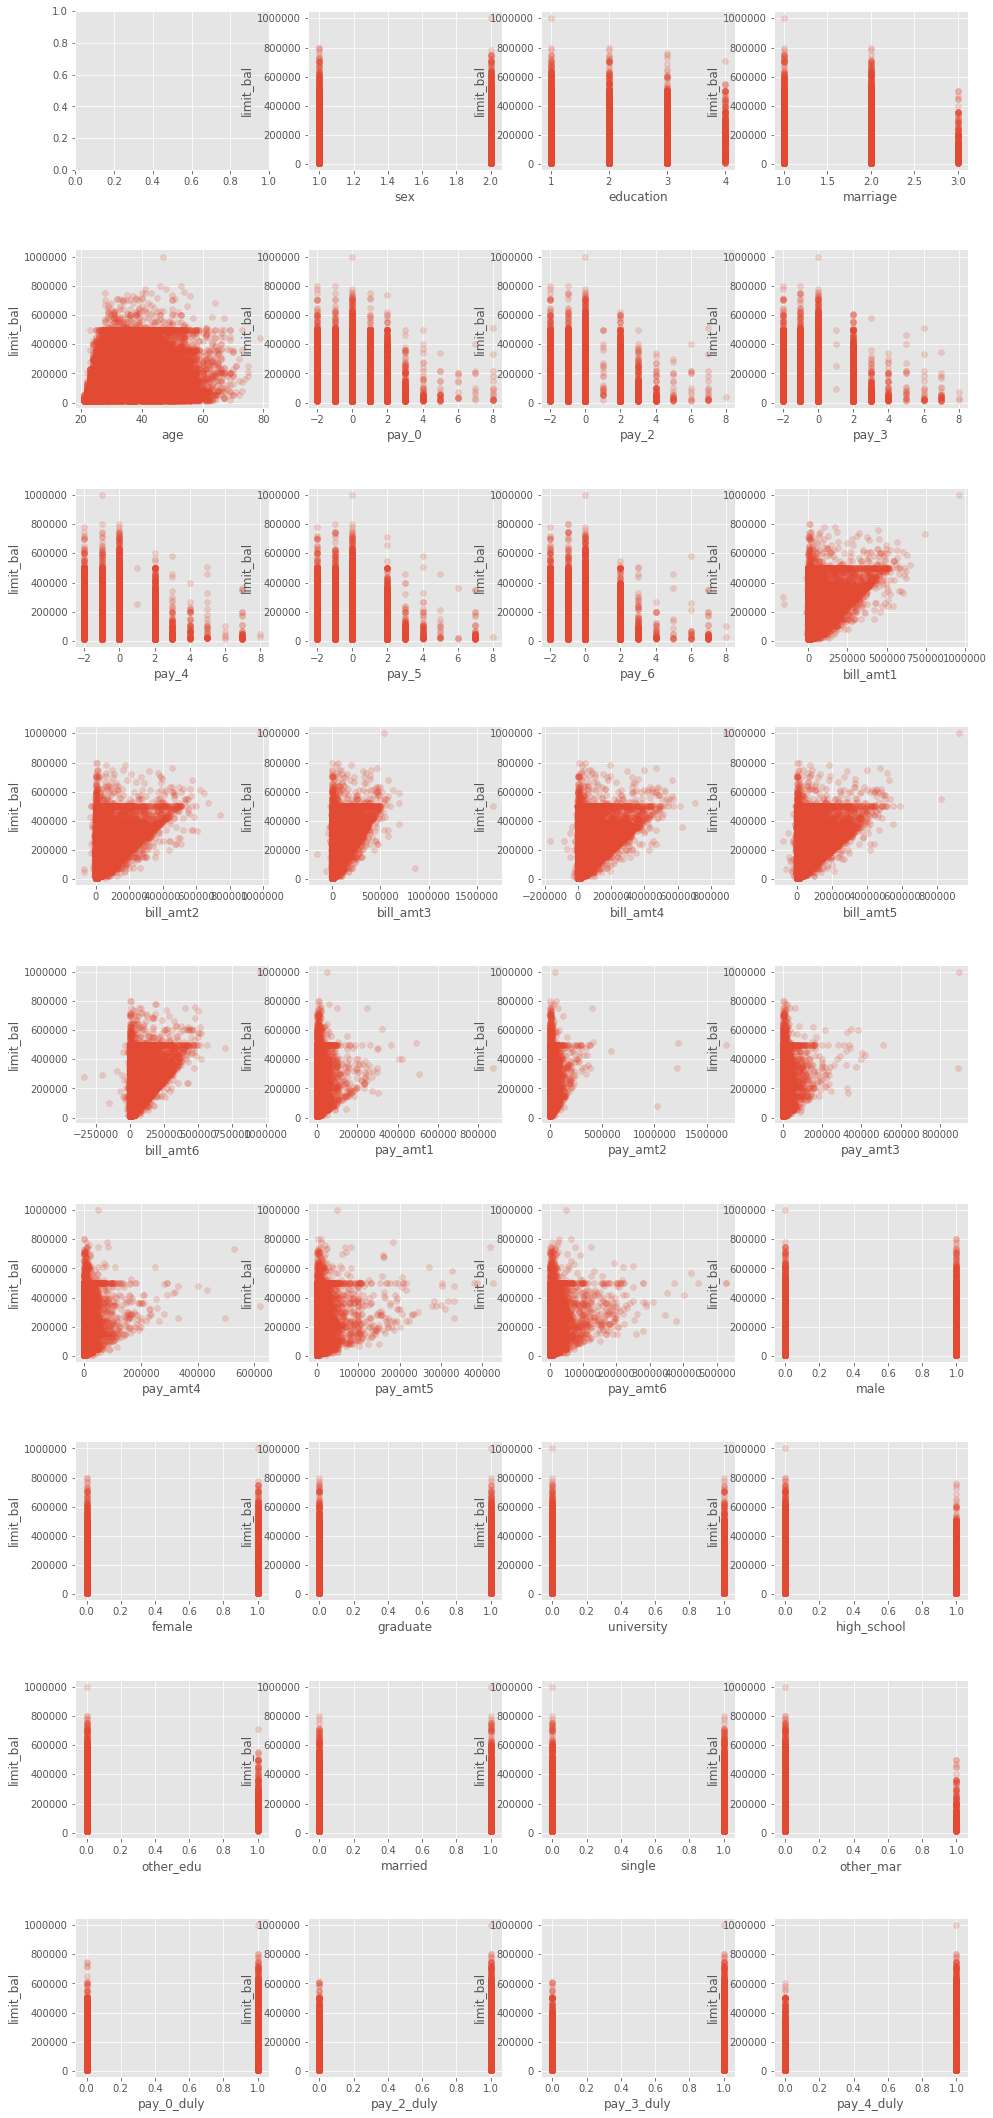

In [42]:
plot_against_target(df, target_col="limit_bal", exclude=["default_payment_next_month"])

In [33]:
def get_interaction_df(df, depth=2):
    from itertools import combinations as iter_combinations
    if depth < 2:
        return None
    combinations = list(iter_combinations(df.columns, depth))
    interactions = []
    for combo in combinations:
        interaction = df[combo[0]]
        for i in range(1,len(combo)):
            try:
                interaction = interaction * df[combo[i]]
            except:
#                 print(interaction, df[combo[i]])
                print(combo[i])
#                 printf("interaction type: %s\t df[combo] type: %s\n", interaction.dtype, df[combo[i]].dtypes)
        interactions.append(interaction)
    int_df = pd.concat(interactions, axis=1)
    int_df.columns = ["_".join(combo) for combo in combinations]
    return int_df


interactions_df = get_interaction_df(pd.DataFrame(X, columns=list(filter(lambda x: x != "default_payment_next_month", df.columns))))

In [45]:
def get_mem_usage(hidden=True, echo=False):
    total = 0
    for var in globals():
        if re.search(r"^_", var) and not hidden:
            continue
        if echo:
            printf("%s: \n", var)
            size_info(globals()[var])
        total += sys.getsizeof(globals()[var])
    printf("%f Mb\n", total * 1024 ** -2)
    printf("%d bytes\n", total)


get_mem_usage()

255.436780 Mb
267844877 bytes


In [37]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [40]:
@jit
def simple_feature_evaluation(X, y, n_splits=10):
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    y = np.array(y)
    result = []
    for c in X.columns:

        x = np.array(X[c]).reshape(-1, 1)
        avg_f1 = 0
        avg_precision = 0
        avg_recall = 0

        clf = LogisticRegression(solver="lbfgs")

        avg_accuracy = 0
        avg_f1 = 0
        avg_precision = 0
        avg_recall = 0
        for train_index, test_index in cv.split(x):
            X_train, X_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]

            clf.fit(X_train, y_train)
            preds = clf.predict(X_test)
            prob_preds = clf.predict_proba(X_test)

            if preds.sum() == 0:
                continue
            avg_accuracy += accuracy_score(y_test, preds)
            avg_f1 += f1_score(y_test, preds)
            avg_precision += precision_score(y_test, preds)
            avg_recall += recall_score(y_test, preds)

        avg_accuracy /= n_splits
        avg_f1 /= n_splits
        avg_precision /= n_splits
        avg_recall /= n_splits
        result.append(
            {
                "field": c,
                "avg_accuracy": avg_accuracy,
                "avg_precision": avg_precision,
                "avg_f1": avg_f1,
                "avg_recall": avg_recall,
            }
        )
    return result

In [41]:
interaction_evaluation = simple_feature_evaluation(interactions_df, y)

KeyboardInterrupt: 

In [ ]:
df_evaluation = simple_feature_evaluation(df, y)

In [ ]:
import json

In [ ]:
with open("interaction_evaluation.json", "w") as f:
    f.write(json.dumps(interaction_evaluation))

In [ ]:
with open("df_evaluation.json", "w") as f:
    f.write(json.dumps(df_evaluation))

In [63]:
!ls

ABOUT_DATA.md			    interaction_evaluation.json
creditcard.csv			    modeling.ipynb
creditcardfraud.zip		    notes.md
default_of_credit_card_clients.csv  prospects.md
df_evaluation.json		    README.md
eda_transform.ipynb		    selected_features.csv
finalize_data.py		    smart.gif


In [64]:
?json

* Take n things from each score metric and remove duplicate columns

In [65]:
interaction_evaluation_saved = None
with open("interaction_evaluation.json", "r") as f:
    interaction_evaluation_saved = json.loads(f.read())
print(type(interaction_evaluation_saved))

<class 'list'>


In [66]:
df_evaluation_saved = None
with open("df_evaluation.json", "r") as f:
    df_evaluation_saved = json.loads(f.read())
print(type(df_evaluation_saved))

<class 'list'>


In [67]:
evaluation_keys = ["field", "avg_accuracy", "avg_precision", "avg_f1", "avg_recall"]


def json_from_file(name):
    result = None
    with open(name, "r") as f:
        result = json.loads(f.read())
        return result


def get_top_percent_features(data, percent):
    if not (0 < percent and percent < 100):
        return None

    global evaluation_keys
    m = int(percent * len(data) / 100)
    result = set([])
    for k in evaluation_keys:
        if k == "field":
            continue
        metric_sorted = sorted(data, key=lambda x: x[k], reverse=True)
        fields_sorted = list(map(lambda x: x["field"], metric_sorted))
        for i in range(m):
            result.add(fields_sorted[i])
#             result.append(fields_sorted[i])
    return result


# "field", "avg_accuracy", "avg_precision", "avg_f1", "avg_recall"
# dict_keys(['field', 'avg_accuracy', 'avg_precision', 'avg_f1', 'avg_recall'])
df_evaluation_saved = json_from_file("df_evaluation.json")
interaction_evaluation_saved = json_from_file("interaction_evaluation.json")
final_interaction_labels = get_top_percent_features(interaction_evaluation_saved, 10)
final_df_labels = get_top_percent_features(df_evaluation_saved, 50)

In [68]:
printf("len(df.columns): %d\n", len(df.columns))
printf("len(final_df_label): %d\n", len(final_df_labels))
printf("len(final_interaction_label): %d\n", len(final_interaction_labels))
printf("len(interactions_df.columns): %d\n", len(interactions_df.columns))

len(df.columns): 39
len(final_df_label): 19
len(final_interaction_label): 181
len(interactions_df.columns): 703


In [ ]:
final_df_labels

In [69]:
final_df = pd.concat([df[list(final_df_labels)], interactions_df[list(final_interaction_labels)]], axis=1)

In [70]:
final_df.head()

,pay_3_duly,pay_2_duly,pay_4,bill_amt6,bill_amt2,pay_5_duly,default_payment_next_month,bill_amt1,pay_0,bill_amt5,bill_amt4,bill_amt3,pay_3,pay_4_duly,pay_2,pay_5,pay_6_duly,pay_0_duly,pay_6,pay_amt5_pay_0_duly,pay_amt2_other_edu,pay_2_duly_pay_4_duly,bill_amt1_bill_amt5,bill_amt4_pay_0_duly,male_other_edu,pay_0_duly_pay_3_duly,pay_3_duly_pay_4_duly,bill_amt1_pay_3_duly,pay_0_bill_amt3,bill_amt4_other_edu,education_pay_2,pay_2_single,bill_amt5_other_edu,pay_3_bill_amt1,bill_amt2_pay_2_duly,marriage_other_mar,pay_amt1_other_mar,pay_0_duly_pay_6_duly,pay_4_bill_amt3,limit_bal_pay_5_duly,pay_4_bill_amt1,other_mar_pay_6_duly,other_edu_pay_6_duly,pay_3_duly_pay_6_duly,bill_amt6_pay_2_duly,bill_amt2_other_mar,pay_amt4_pay_0_duly,pay_amt2_pay_2_duly,bill_amt4_other_mar,other_edu_single,pay_6_high_school,pay_5_bill_amt3,pay_amt4_other_edu,other_mar_pay_2_duly,bill_amt1_pay_0_duly,other_mar_pay_3_duly,pay_5_bill_amt1,graduate_pay_0_duly,bill_amt6_other_edu,marriage_pay_2,pay_3_pay_amt4,pay_2_bill_amt2,bill_amt2_pay_0_duly,pay_3_university,pay_amt6_other_edu,bill_amt6_other_mar,pay_5_bill_amt6,pay_6_other_edu,pay_5_other_edu,bill_amt5_other_mar,pay_4_bill_amt6,pay_0_bill_amt1,bill_amt3_pay_0_duly,pay_6_male,female_other_mar,sex_pay_0_duly,pay_2_bill_amt4,other_edu_pay_2_duly,pay_3_pay_amt3,limit_bal_pay_6_duly,female_other_edu,bill_amt3_other_edu,pay_amt1_other_edu,pay_amt3_other_mar,pay_4_bill_amt2,pay_3_bill_amt2,education_pay_0,pay_2_duly_pay_6_duly,education_other_mar,pay_5_bill_amt2,pay_2_duly_pay_5_duly,other_edu_pay_0_duly,pay_0_university,education_pay_3,pay_4_duly_pay_5_duly,other_edu_married,pay_amt5_other_mar,pay_amt1_pay_3_duly,pay_amt2_pay_3_duly,bill_amt6_pay_0_duly,pay_amt6_pay_0_duly,pay_3_male,bill_amt1_pay_2_duly,pay_5_duly_pay_6_duly,sex_other_edu,marriage_pay_0_duly,pay_3_bill_amt6,limit_bal_other_mar,pay_amt3_pay_0_duly,age_other_edu,pay_amt3_other_edu,pay_0_duly_pay_5_duly,pay_0_graduate,graduate_married,bill_amt1_other_mar,bill_amt1_other_edu,pay_0_duly_pay_4_duly,limit_bal_pay_2_duly,pay_amt4_other_mar,pay_4_high_school,limit_bal_pay_4_duly,pay_5_university,pay_3_high_school,pay_0_high_school,age_other_mar,high_school_other_mar,pay_0_pay_amt4,pay_2_duly_pay_3_duly,pay_amt2_pay_0_duly,high_school_pay_2_duly,other_edu_pay_4_duly,other_edu_pay_5_duly,pay_2_bill_amt6,pay_2_pay_amt3,bill_amt2_bill_amt5,pay_amt1_pay_0_duly,pay_0_single,pay_4_bill_amt5,pay_3_bill_amt5,pay_2_university,high_school_pay_3_duly,pay_amt1_pay_2_duly,bill_amt4_pay_2_duly,pay_0_married,bill_amt2_other_edu,other_mar_pay_4_duly,bill_amt3_other_mar,pay_6_university,pay_3_other_edu,pay_2_bill_amt5,high_school_pay_0_duly,pay_0_duly_pay_2_duly,age_pay_0_duly,pay_0_bill_amt5,other_mar_pay_5_duly,pay_2_other_edu,bill_amt5_pay_2_duly,bill_amt4_bill_amt6,pay_0_bill_amt2,pay_0_bill_amt4,pay_4_university,pay_5_bill_amt4,pay_0_male,bill_amt1_bill_amt6,pay_3_bill_amt4,pay_2_bill_amt1,marriage_pay_0,sex_pay_0,pay_5_male,single_pay_0_duly,other_mar_pay_0_duly,pay_amt1_pay_4_duly,education_other_edu,pay_0_bill_amt6,sex_other_mar,marriage_other_edu,pay_amt5_other_edu,age_pay_0,limit_bal_pay_0_duly,pay_2_bill_amt3,age_pay_2,pay_4_other_edu,pay_6_bill_amt3,pay_3_duly_pay_5_duly,other_edu_pay_3_duly,bill_amt5_pay_0_duly,pay_0_pay_amt5,bill_amt2_bill_amt6,pay_4_bill_amt4,pay_6_bill_amt1,limit_bal_pay_3_duly,pay_3_bill_amt3,female_pay_0_duly,pay_0_female,pay_6_bill_amt2,pay_2_high_school,pay_2_male,pay_5_bill_amt5,limit_bal_other_edu,bill_amt3_pay_2_duly
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,1.0,3913.0,1378.0,0.0,4.0,0.0,0.0,-3913.0,0.0,0.0,0.0,0.0,-689.0,20000.0,-3913.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-1378.0,0.0,0.0,0.0,0.0,-7826.0,0.0,0.0,2.0,-0.0,6204.0,0.0,-1.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,7826.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,20000.0,0.0,0.0,0.0,0.0,-3102.0,-3102.0,4.0,0.0,0.0,-6204.0,0.0,0.0,2.0,-2.0,1.0,0.0,0.0,0.0,689.0,0.0,0.0,-0.0,0.0,1.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0

In [71]:
final_df.to_csv("selected_features.csv")